## Interpreting DRC

This notebook will give a brief guide for the project of interpreting planning agents. Note that the majority of the code in this repo is used for another planning algorithm called the Thinker, so only a few Python files in this repo are necessary for the project. First, follow the readme to install Sokoban and the Thinker repo. If Sokoban is installed successfully, you should be able to run the following code.

In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch

Environment shape + type: (8, 8, 7) <class 'numpy.ndarray'>


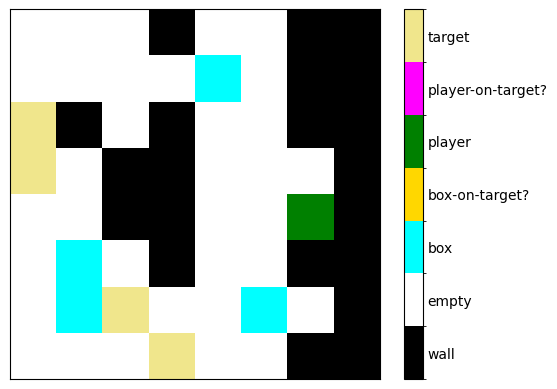

In [2]:
# test if Sokoban is installed sucessfully
mini = True
env = gym.make("Sokoban-v0", mini=mini)
state = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
print("Environment shape + type:", state.shape, type(state))
if mini:
    viz.plot_mini_sokoban(state, True)
else:  
    plt.imshow(state)


## Sokoban
The goal is to push all four boxes to the target space (the red-bordered location). There are five actions: no-op, left, up, down, right. Boxes can only be pushed but not pulled. A reward of +1 is given if a box is pushed onto the target, and an additional +10 reward is given if all four boxes are on the target, which will also end the episode. A reward of -1 is given if a box on the target is pushed away from it. A reward of -0.01 is added at every time step to encourage solving the task as quickly as possible. The maximum length of each episode is around 120 steps, after which the episode is forced to terminate.

Initializing env 0 with device cpu


Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


torch.Size([4, 7, 8, 8]) <class 'torch.Tensor'>


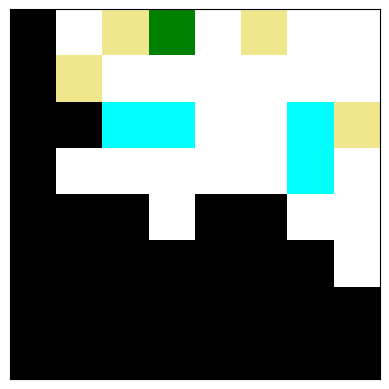

In [3]:
# test if Thinker is installed sucessfully
# the thinker.make environment return a batched environment; here we use a batch size of 16

env_n = 4 # batch size of the environment; can be increased to like 128 if using GPU
gpu = False # change to True for using GPU instead of CPU
mini_sokoban = True # if True, use mini-sokoban board (i.e. board is 8x8x7 array)

env = thinker.make(
    "Sokoban-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, # wrapper_type 1 means default environment without Thinker-augmentation
    has_model=False, # the following arg are mainly for Thinker-augmentation only
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban     
    ) 
state = env.reset()
for _ in range(10):
    action = torch.tensor(env.action_space.sample())
    state, reward, done, info = env.step(action)
print(state["real_states"].shape, type(state["real_states"]))
if mini_sokoban:
    viz.plot_mini_sokoban(state["real_states"][0])
else:
    util.plot_raw_state(state["real_states"][0])

In [ ]:
env.name

In [4]:
# now let's define a DRC agent
from thinker.actor_net import DRCNet

flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) # the default flags; almost all of them won't be used in DRC
flags.mini = mini
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

# define initial RNN-state of DRC
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state) # actor_out contains both the critic and actor output of DRC

# should take less than a few minutes to complete 100 episodes; average return should be around -1.00
episode_returns = []
while(len(episode_returns) < 10):
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, rnn_state = drc_net(env_out, rnn_state)
    # record done episode
    if torch.any(done):
        episode_returns.extend(info["episode_return"][done].tolist())
    
print("Average return: %.2f" % torch.mean(torch.tensor(episode_returns)))

Average return: -0.51


In [5]:
# now let load a trained DRC agent
import os
ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep49500192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

# create list to store agent+env states
agent_env_list = []

# define initial RNN-state of DRC
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state) # actor_out contains both the critic and actor output of DRC

# create and activate logit lens
from thinker.logitlens import DRCTickLogitLens
drc_lens = DRCTickLogitLens(drc_net=drc_net)
drc_lens.activate()
logit_list = []

episode_returns = []
while(len(episode_returns) < 10):
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, rnn_state = drc_net(env_out, rnn_state)
    logit_list.append(drc_lens.get_logits(env_out))
    agent_env_list.append((drc_net.hidden_state, state["real_states"]))
    # record done episode
    if torch.any(done):
        episode_returns.extend(info["episode_return"][done].tolist())

drc_lens.deactivate()
    
print("Average return: %.2f" % torch.mean(torch.tensor(episode_returns))) # should have a return of around 13, i.e. over 90% solving rate

Average return: 12.25


In [ ]:
from thinker.viz_utils import create_gif_multi_env_single_channel, create_gif_single_env_multi_channels
for layer in [0,1,2]:
    for channel in range(64):
        create_gif_multi_env_single_channel(agent_env_list=agent_env_list,
                                            envs=[0,1,2,3], layer=layer,
                                            channel=channel, 
                                            mini=True, 
                                            gif_name=f"layer{layer}_channel{channel}")

In [6]:
def make_feature_detector(feature_idx, mode):
    """Create feature detector functions to extract features from mini-sokoban boards. Boards must be (7,8,8) arrays
    Args:
        feature_idx (int): index of feature of interest (see sokoban.cpp)
        mode (str): either "adj" (to count number of adjacent features) or "num" (to count total number of features on board)
    """
    assert mode in ["adj", "num"], "Please enter a valid mode - either ADJ or NUM"
    if mode == "adj":
        def feature_detector(board):
            h, w = board.shape[1:]
            x, y = ((board[4,:,:]==1) + (board[5,:,:]==1)).nonzero()[0,:]
            adj_coords = [(xp, yp) for xp, yp in [(x+1,y), (x-1,y), (x,y+1), (x,y-1)] if xp>-1 and xp<h and yp>-1 and yp<w]
            n_hits = 0
            for (xp,yp) in adj_coords:
                if board[feature_idx, xp, yp] == 1:
                    n_hits += 1
            return n_hits
    else:
        def feature_detector(board):
            return torch.sum((board[feature_idx,:,:]==1).int()).item()
    return feature_detector


In [7]:
adj_wall_detector = make_feature_detector(feature_idx=0, mode="adj")
adj_boxnotontar_detector = make_feature_detector(feature_idx=2, mode="adj")
adj_boxontar_detector = make_feature_detector(feature_idx=3, mode="adj")
adj_tar_detector = make_feature_detector(feature_idx=6, mode="adj")
num_boxnotontar_detector = make_feature_detector(feature_idx=2, mode="num")
feature_fncs = [
    ("adj_walls", adj_wall_detector),
    ("adj_boxnotontar", adj_boxnotontar_detector),
    ("adj_boxontar", adj_boxontar_detector),
    ("adj_tar_detector", adj_tar_detector),
    ("num_boxnotontar_detector", num_boxnotontar_detector)
]

In [7]:
util.full_path(ckp_path)

'/home/tom/mlmi/dissertation/thinker_private_planning/logs/thinker/drc_base/ckp_actor.tar'

In [8]:
env = thinker.make(
    "Sokoban-v0", 
    env_n=1, 
    gpu=gpu,
    wrapper_type=1, # wrapper_type 1 means default environment without Thinker-augmentation
    has_model=False, # the following arg are mainly for Thinker-augmentation only
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban 
    ) 

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


In [26]:

from torch.utils.data.dataset import Dataset

class ProbingDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

probing_data = []
episode_entry = []

rnn_state = drc_net.initial_state(batch_size=1, device=env.device)

# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state) # actor_out contains both the critic and actor output of DRC
episode_length = 0
board_num = 0

episode_returns = []
while(len(episode_returns) < 10):

    if episode_length > 0:
        step_entry["reward"] = reward.item()
        episode_entry.append(step_entry)

    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, rnn_state = drc_net(env_out, rnn_state)

    step_entry = {feature:fnc(state["real_states"][0]) for feature, fnc in feature_fncs}
    step_entry["action"] = actor_out.action.item()
    step_entry["board_state"] = state["real_states"][0]
    step_entry["hidden_states"] = drc_net.hidden_state
    step_entry["board_num"] = board_num
    episode_length += 1

    if done:
        for step, step_entry in enumerate(episode_entry):
            step_entry["episode_length"] = episode_length
            step_entry["steps_remaining"] = episode_length - step
            step_entry["action_plus1"] = episode_entry[step+1]["action"] if step < episode_length-2 else 9
            step_entry["action_plus2"] = episode_entry[step+2]["action"] if step < episode_length-3 else 9
            step_entry["action_plus3"] = episode_entry[step+3]["action"] if step < episode_length-4 else 9
            step_entry["action_plus4"] = episode_entry[step+4]["action"] if step < episode_length-5 else 9
            step_entry["action_plus5"] = episode_entry[step+5]["action"] if step < episode_length-6 else 9
            step_entry["reward_plus1"] = episode_entry[step+1]["reward"] if step < episode_length-2 else 9
            step_entry["reward_plus2"] = episode_entry[step+2]["reward"] if step < episode_length-3 else 9
            step_entry["reward_plus3"] = episode_entry[step+3]["reward"] if step < episode_length-4 else 9
            step_entry["reward_plus4"] = episode_entry[step+4]["reward"] if step < episode_length-5 else 9
            step_entry["reward_plus5"] = episode_entry[step+5]["reward"] if step < episode_length-6 else 9
        probing_data += episode_entry
        episode_returns.extend(info["episode_return"][done].tolist())
        episode_length = 0
        board_num += 1

probing_dataset = ProbingDataset(probing_data)


In [24]:
torch.save(probing_dataset, './probe.pt')

In [25]:
dataset = torch.load("./probe.pt")

In [17]:
len(episode_entry)

26

In [77]:
min(env.action_space)

Discrete(5)

In [73]:
for step, step_entry in enumerate(episode_entry):
    step_entry["episode_length"] = episode_length
    step_entry["steps_remaining"] = episode_length - step
    step_entry["action_plus1"] = episode_entry[step+1] if step < episode_length-1 else 9
    step_entry["action_plus2"] = episode_entry[step+2] if step < episode_length-2 else 9
    step_entry["action_plus3"] = episode_entry[step+3] if step < episode_length-3 else 9
    step_entry["action_plus4"] = episode_entry[step+4] if step < episode_length-4 else 9
    step_entry["action_plus5"] = episode_entry[step+5] if step < episode_length-5 else 9

In [ ]:
probing_dataset = ProbingDataset(probing_data)

In [71]:
probing_data[0]

{'adj_walls': 1,
 'adj_boxnotontar': 0,
 'adj_boxontar': 0,
 'adj_tar_detector': 0,
 'num_boxnotontar_detector': 4,
 'action': 2,
 'board_state': tensor([[[1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 1],
          [1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0]],
 
         [[0, 0, 0, 1, 0, 1, 1, 1],
          [0, 0, 1, 0, 1, 1, 0, 1],
          [0, 0, 0, 0, 1, 1, 1, 1],
          [0, 0, 0, 0, 1, 1, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 1],
          [0, 0, 1, 1, 1, 0, 0, 1],
          [0, 0, 1, 0, 1, 0, 1, 1],
          [0, 0, 0, 0, 0, 1, 1, 1]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 1, 0, 0],
          [0, 0, 0, 0

{'real_done': tensor([True]),
 'truncated_done': tensor([False]),
 'cost': tensor([False]),
 'episode_return': tensor([13.0100], dtype=torch.float64),
 'episode_step': tensor([99]),
 'step_status': tensor([3]),
 'model_status': {'processed_n': 0,
  'warm_up_n': 0,
  'running': False,
  'finish': True}}

In [58]:
episode_entry

[{'adj_walls': 0,
  'adj_boxnotontar': 1,
  'adj_boxontar': 0,
  'adj_tar_detector': 0,
  'num_boxnotontar_detector': 1,
  'reward': -0.009999999776482582,
  'episode_length': 99,
  'steps_remaining': 99},
 {'adj_walls': 1,
  'adj_boxnotontar': 0,
  'adj_boxontar': 0,
  'adj_tar_detector': 1,
  'num_boxnotontar_detector': 4,
  'reward': -0.009999999776482582,
  'episode_length': 99,
  'steps_remaining': 98},
 {'adj_walls': 0,
  'adj_boxnotontar': 0,
  'adj_boxontar': 0,
  'adj_tar_detector': 0,
  'num_boxnotontar_detector': 4,
  'reward': -0.009999999776482582,
  'episode_length': 99,
  'steps_remaining': 97},
 {'adj_walls': 0,
  'adj_boxnotontar': 0,
  'adj_boxontar': 0,
  'adj_tar_detector': 0,
  'num_boxnotontar_detector': 4,
  'reward': -0.009999999776482582,
  'episode_length': 99,
  'steps_remaining': 96},
 {'adj_walls': 2,
  'adj_boxnotontar': 0,
  'adj_boxontar': 0,
  'adj_tar_detector': 0,
  'num_boxnotontar_detector': 4,
  'reward': -0.009999999776482582,
  'episode_length': 

In [33]:
drc_net.hidden_state[0].shape

torch.Size([4, 192, 8, 8])

## Misc

You can directly access the stacked hidden state by `.hidden_state` after each call to drc_net:

`print(drc_net.hidden_state.shape) # should be [16, 4, 192, 10, 10]`

16 is the batch size; 4 is the four hidden state for the three inner ticks (h_0, h_1, h_2, h_3); 192 is the stacked channel (each RNN-layer has 64 channel, and there are 3 RNN-layers); 10 are the width and height 

## Relevant Files

- `thinker/actor_net.py` contains the DRC network
- `thinker/core/rnn.py` contains the DRC-block used for building DRC
- `learn_actor.py` contains the code for training the agent; not necessary for this project unless you need to train a new agent

In case you want to train a new DRC agent, run (take around a day for a 3090):

`python train.py --xpid drc --drc true --actor_unroll_len 20 --reg_cost 1 --actor_learning_rate 4e-4 --entropy_cost 1e-2 --v_trace_lamb 0.97 --actor_adam_eps 1e-4 --has_model false`
